# Names:
## Aamir Ahmad Ansari
## Ibtisam
## Sarath Manoj
## Utkarsh Raj

## Problem Statement:
One of the most fascinating problems to solve when it comes to deep learning is speech to text conversion. In this project we tend to solve the same and for the voices of Univ.Ai.

## Proposed Solution:
The proposed solution is a hybrid Convolutional Neural Network and GRU model inspired by the DeepSpeech2 model propose by Hanun et al.(2015). The CNN and GRU hybrid gives us a perfect solution for what we want to do; we want to take localised information of the speech spectrogram as not every utterance corresponds to a word which we achieve through CNN’s, while we harness the power of sequential data computing with GRU which works as a language model to convert the speech to text. 
This hybrid model will be pretrained on a large speech data set which will work as the base to build upon to decode the Univ voice to text.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython.display import Audio 
import librosa.display
from IPython.core.display import display
from sklearn.model_selection import train_test_split
from IPython import display
import librosa
import os
from jiwer import wer
import re
from keras.models import load_model
from helper_main import  *

In [ ]:
############################## For restricting the GPU memory ##########################
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## Data Preprocessing
The LJ Speech data is clear and neately transcribed. There are almost 13k+ audio files sampled at 22050Hz, which is standard for audio data with 16 bit PCM. The Univ data we extract is processed in the same environment 22050Hz and 16 bit PCM. We preprocess both the text and the audio files before feeding it to our network.


### Audio Data Pre-Processing
The audio data is read and decoded and then passed to do a short time fourier transform operation which gives us the input spectrogram. This converts the signal from time domain to frequency domain with some information of time. A signal is easier to analyse in frequency domain then the time domain. This stft transformation is then normalized. 

Adding white gaussian noise before the signal is the only data augmentation technique used in [1] which we followed while modelling the large model.

### Text Data Pre-Processing
The text data cannot be fed directly to the machine learning models hence we first tokenize them on character level( to use with our loss function). We created a tokenizer which does this work for us. We included some common special characters like ? . , ' \t in the vocabulary. With all the english alphabets and some of our special characters our vocabulary size was just over 40. The text is first converted all to lower representation and then tokenized.

All these modifications and transformations we save in a tensorflow dataset api, with a batch size of 16/32. We add padding using padded_batches function in the api.


In [ ]:
############ Reading the csv file with file names and corresponding transcripts ##############
wavs_path='LJSpeech-1.1/wavs/'
metadata_df = pd.read_csv('LJSpeech-1.1/metadata.csv', sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
df_train, df_val = train_test_split(metadata_df,test_size=0.1) # splitting the data
print('Total number of files:',metadata_df.shape[0])
df_train.head()

Total number of files: 13100


,file_name,normalized_transcription
5850,LJ019-0316,Hard labor of the first and second class was c...
3027,LJ011-0120,"Unfortunately he took to drink, lost his appoi..."
7117,LJ027-0038,between the heart of an insect and the heart o...
2967,LJ011-0060,He wrote afterwards to the effect that the mom...
10642,LJ040-0209,well I've got to live with her. I guess I love...


In [ ]:
############# Creating character level Tokenizer for our text data #####################
class Tokenizer:
    def __init__(self):
        self.vocab=[]
        self.charToIdx={}
        self.idxToChar={}
        self.specialChars='[!"$£%&()*+/:;=@[\\]^_`{|}~\n]<>'  
        self.counter=0
        self.initialise()
    
    def initialise(self):
        self.vocab=["-", "#"," ", ".", ",", "?","'"] + [chr(i + 96) for i in range(1, 27)] + [str(i) for i in range(10)]
        self.charToIdx={v:k+1 for k,v in enumerate(self.vocab)}
        self.idxToChar={v:k for k,v in self.charToIdx.items()}
        #OOV TOKEN
        self.idxToChar[0]=''
        self.charToIdx['']=0
        
    def transform(self,text,padFrom='end'):
        text=text.lower()
        text=text
        text=re.sub(self.specialChars,'',text)
        text=re.sub("'",'',text)
        tokens= [self.charToIdx.get(i,0) for i in text]
        
        if padFrom=='end':
            return tokens
        else:
            return tokens
    
    def textsToSequences(self,seq):
        tokens=[]
        for i in seq:
            tokens.append(self.transform(i))
        return tokens
    
    def sequencesToText_2(self,seq):
        texts=[]
        for i in seq:
                sent=self.idxToChar.get(i,'')
                texts.append(sent)
        return texts
    
    def sequencesToText(self,seq):
        texts=[]
        for i in seq:
            sent=""
            for j in i:
                sent+=self.idxToChar.get(j,'')
            texts.append(sent)
        return texts
        
        

In [ ]:
####################### Generating STFT spectrograms from our audio files ########################
fft_length = 384
def preprocess(af, text):
    file = tf.io.read_file(wavs_path+ af + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    ##### Adding Noise ######
    choice=np.random.choice([1,2],1)
    if choice==1:
        pass
    elif choice==2:
        gaussian=tf.random.normal(shape=tf.shape(audio),stddev=tf.math.reduce_std(audio))
        audio=gaussian+audio
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(audio, frame_length=256, frame_step=160, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    return spectrogram, text

In [ ]:
######################### Generating the tf.Datasets ########################
def tensor_dataset(df_train,df_val,batch_size=16):
    batch_size = 16

    tokenized_train=tf.ragged.constant(Tokenizer().textsToSequences(df_train["normalized_transcription"]))
    tokenized_val=tf.ragged.constant(Tokenizer().textsToSequences(df_val["normalized_transcription"]))

    train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), tokenized_train))
    train_dataset = (train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))

    validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]), tokenized_val))
    validation_dataset = (validation_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE))
    return train_dataset,validation_dataset

train_dataset,validation_dataset=tensor_dataset(df_train,df_val,batch_size=16)

<Figure size 576x360 with 0 Axes>

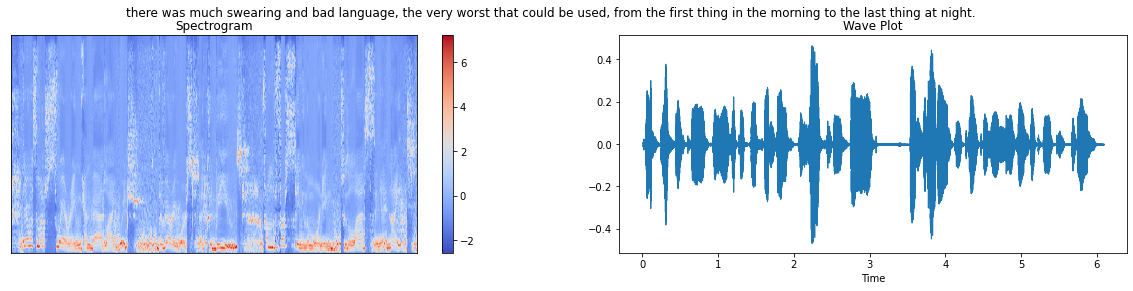

In [ ]:
####################### Visualizing audio files #######################
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    fig,(ax0,ax1)=plt.subplots(1,2,figsize=(20,4))

    #Spectrogram
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    lib=librosa.display.specshow(spectrogram,ax=ax0)
    fig.colorbar(lib,ax=ax0)
    ax0.set_title("Spectrogram")
   
    y, sr = librosa.load(wavs_path + list(df_train["file_name"])[1] + ".wav")  # Wave plot
    librosa.display.waveshow(y,ax=ax1)
    ax1.set_title("Wave Plot")

    text = batch[1][0]
    text = Tokenizer().sequencesToText([text.numpy()])
plt.suptitle(text[0])
plt.show()

## Understanding the Architecture
Our Architecture consists of Convolutional layers, GRU layers and dense layers. Lets understand their significance in the model one by one.

### Convolutional Layers
Convolutional layers are very popular in image classification as it captures the local information using shared weights and we apply the same idea on our spectrograms to obtain the localised information of the utterances. There is a difference how we use the CNN layers for image classification and speech recoginition; we take large filters. Not all utterances will make some things meaniful, it takes a group of them to form some words and hence to cover them we use large filters. The strides are used in frequency domain. The original paper[1] advices to use only 2 to 3 CNN layers, hence we have two models small and large with 2 and 3 CNN layers. These models also differ in GRU layers which will understand in the next section. The CNN layers provides rich embeddings to the GRU layers to work with.

### GRU Layers 
The Gated Recurrent unites are an advancement in the traditional RNN's by providing update and reset gates to resolve the inability of having long-term memory in RNN's. These layers gives us the power of sequential computing and works as an language model. LSTM's could have been used but as it says in the original paper[1] the performance is the same plus we can train the GRU's faster. It also suggests that the GRU layers to be used should be around 5 to 7 and we have implemented both in the small and the large models respectievly.

### Dense Layers
The dense layers are used to flatten on the previous output followed by a softmax layer which is of the length of the vocabulary which gives us the probability distribution for each predicted character.

#### Importing the large model - 7 layers Bidirectional GRU layers and 3 CNN layers - as proposed in the Nvidia Deepspeech implementation

In [ ]:
model = Model(fft_length // 2 + 1,len(Tokenizer().vocab)+1).getModel('large')
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = Tokenizer().sequencesToText(results.numpy())
    return output_text

## Loss and Metrics 

### CTC Loss 
Connectionist Temporal Classification (CTC) loss is a traditional loss function the tasks of handwriting and speech recoginition . The advantage of the loss of sparse categorical crossentropy or categorical crossentropy is that it doesn't require any alignment between the input and the output. It assigns the probabilities to each possible alignment and maximises to the probability to the correct one.

The objective of th ctc loss is to maximise the probability of the correct alignment, the objective is given by:

$${p( Y | X ) = }\sum_{} \prod_{t=1}^{T}p_t( a_t | X )$$

where $a_t$ is the single alignment.

### Word Error Rate 
The wer is calculated as the number of deletions, insertions and substitutions normaloized by the number of words present in the output. It is a traditional metrics for handwriting and speech recoginition. Besides being a classic problem of dynamic programming it solves our quest to know how well we are recognizing the speech. 

$${WER = }\frac{S + I + D}{N}$$

where S, I and D are number of substitutions, Insertions and deletions respectively.

#### First we trained over 27 epochs to check the results and then again for 23 epochs to complete a total of 50 epochs as recommended by the authors[3].

In [ ]:
############################### Fitting the model #######################
epochs = 23

backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="Weights_callback")
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[backup_callback])

Epoch 1/23
737/737 [==============================] - 1470s 2s/step - loss: 24.1604 - val_loss: 20.8442
Epoch 2/23
737/737 [==============================] - 1129s 2s/step - loss: 20.5835 - val_loss: 21.3306
Epoch 3/23
737/737 [==============================] - 1129s 2s/step - loss: 18.9461 - val_loss: 21.3612
Epoch 4/23
737/737 [==============================] - 1127s 2s/step - loss: 17.9107 - val_loss: 25.6310
Epoch 5/23
737/737 [==============================] - 1130s 2s/step - loss: 17.4808 - val_loss: 22.1744
Epoch 6/23
737/737 [==============================] - 1126s 2s/step - loss: 16.2632 - val_loss: 23.4173
Epoch 7/23
737/737 [==============================] - 1128s 2s/step - loss: 15.8617 - val_loss: 24.3526
Epoch 8/23
737/737 [==============================] - 1130s 2s/step - loss: 15.3289 - val_loss: 24.2050
Epoch 9/23
737/737 [==============================] - 1130s 2s/step - loss: 14.9470 - val_loss: 24.8479
Epoch 10/23
737/737 [==============================] - 1137s 2s/

## Results

In [ ]:
val_loss={1: '20.8442', 2: '21.3306', 3: '21.3612', 4: '25.6310', 5: '22.1744', 6: '23.4173', 7: '24.3526', 8: '24.2050', 9: '24.8479', 10: '25.1304', 11: '36.1671', 12: '26.7567', 13: '25.8019', 14: '26.0576', 15: '27.6389', 16: '26.7602', 17: '26.3942', 18: '27.6217', 19: '28.6326', 20: '27.0533', 21: '29.2087', 22: '27.5610', 23: '27.7189'}
loss={1: '24.1604', 2: '20.5835', 3: '18.9461', 4: '17.9107', 5: '17.4808', 6: '16.2632', 7: '15.8617', 8: '15.3289', 9: '14.9470', 10: '14.2770', 11: '14.5117', 12: '14.2802', 13: '12.8852', 14: '12.8481', 15: '13.0490', 16: '12.4991', 17: '11.9511', 18: '11.9048', 19: '11.4136', 20: '11.3473', 21: '11.1168', 22: '10.8005', 23: '10.8481'}

C:\Users\admin\AppData\Local\Temp/ipykernel_5156/680869309.py:15: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set_yticks(np.arange(start,end,5))


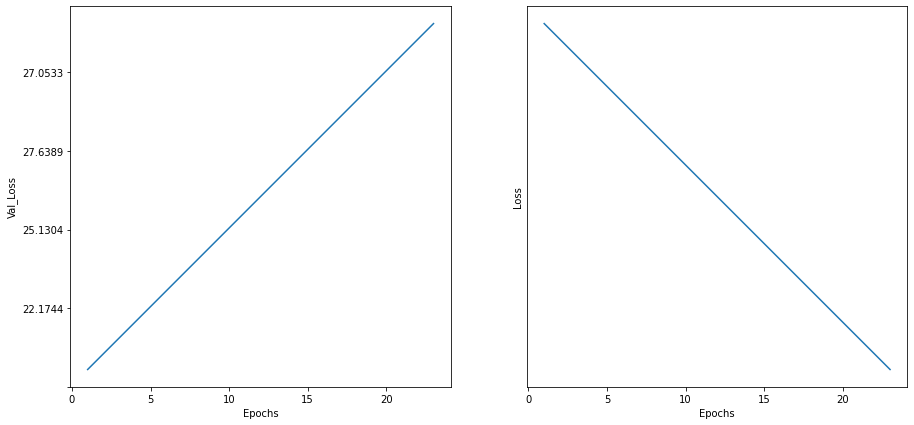

In [ ]:
#################### Loss plots ######################
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(15,7))

ax0.plot(val_loss.keys(),val_loss.values())
ax1.invert_yaxis()
ax1.plot(loss.keys(),loss.values())
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Val_Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

start,end=ax0.get_ylim()
ax0.set_yticks(np.arange(start,end,5))
start,end=ax1.get_ylim()
ax1.set_yticks(np.arange(start,end,5))
plt.show()

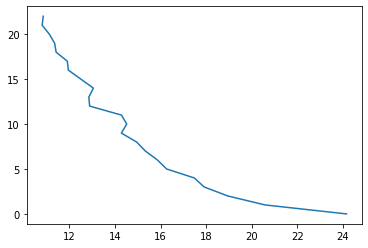

In [ ]:
#################### Previous Loss plots ----- Couldn't make prepare it completely due to crashing of kernel ######################
plt.plot(history.history['loss'],range(epochs))

##### Prediction for large model

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(Tokenizer().sequencesToText_2(label.numpy())).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 322ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0572
----------------------------------------------------------------------------------------------------
Target    : because other types of fibers present in the blanket were not found in the bag.
Prediction: because other types of fibers present in the blanket were not found in the bag.
----------------------------------------------------------------------------------------------------
Target    : thurtell was a gambler, and weare had won a good deal of money from him.
Prediction: thurtell was agambler, and weare had one a good deal of money from him.
----------------------------------------------------------------------------------------------------
Target    : it had established periodic regular review of the status of four hundred individuals
Prediction: it had established periodic regular review of the status 

##### Getting the predictions of smaller model

In [ ]:
# Get the model
model_small = Model(fft_length // 2 + 1,len(Tokenizer().vocab)+1).getModel('small')
model_small.load_weights('abc')

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model_small.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(Tokenizer().sequencesToText_2(label.numpy())).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 259ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.0832
----------------------------------------------------------------------------------------------------
Target    : there were still untoward accidents occasionally at executions, and even the chief practitioner of recent times, calcraft,
Prediction: there were still untoward accidents occasionally at executions and even the chief practitioner of recent times calcraft,
----------------------------------------------------------------------------------------------------
Target    : jeanne de mohrenschildt, however, thought that marina oswald, quote, said things that will hurt mens pride, end quote.
Prediction: jene de mohrenschildt, however, thought that marina oswald, quote, said things that will hurt mens pride, end quote.
--------------------------------------------------------------------------------------------

In [ ]:
############################ Loading the weights/model for future runs #########################
model = tf.keras.models.load_model('my_model_50ep.h5', custom_objects={'CTCLoss': Model(1,2).lossFunc}) 
model.load_weights('weights_extended_model_50ep')

In [ ]:
metadata_df = pd.read_csv('Datasets/univ_splits/Transcription.csv')
metadata_df = metadata_df[["file_name","normalized_transcription"]]
metadata_df['file_name']=metadata_df['file_name'].apply(lambda x:re.sub('.wav','',x))
df_train, df_val = train_test_split(metadata_df,test_size=0.1)

In [ ]:
wavs_path='Datasets/univ_splits/'
train_dataset,validation_dataset=tensor_dataset(df_train,df_val,batch_size=8)

In [ ]:
############################### Fitting the model #######################
# Define the number of epochs.
epochs = 20

backup_call = tf.keras.callbacks.BackupAndRestore(backup_dir="Weights_callback")
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[backup_call])

Epoch 1/20
42/42 [==============================] - 118s 2s/step - loss: 422.6350 - val_loss: 368.3766
Epoch 2/20
42/42 [==============================] - 83s 2s/step - loss: 366.4430 - val_loss: 328.6114
Epoch 3/20
42/42 [==============================] - 87s 2s/step - loss: 358.8783 - val_loss: 338.5390
Epoch 4/20
42/42 [==============================] - 86s 2s/step - loss: 341.6509 - val_loss: 522.8535
Epoch 5/20
42/42 [==============================] - 87s 2s/step - loss: 337.8427 - val_loss: 396.4854
Epoch 6/20
42/42 [==============================] - 85s 2s/step - loss: 330.1928 - val_loss: 317.2698
Epoch 7/20
42/42 [==============================] - 89s 2s/step - loss: 332.7544 - val_loss: 456.6649
Epoch 8/20
42/42 [==============================] - 86s 2s/step - loss: 335.6152 - val_loss: 324.0838
Epoch 9/20
42/42 [==============================] - 88s 2s/step - loss: 327.8874 - val_loss: 367.6499
Epoch 10/20
42/42 [==============================] - 85s 2s/step - loss: 326.8105

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(Tokenizer().sequencesToText_2(label.numpy())).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 339ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0114
----------------------------------------------------------------------------------------------------
Target    : average of the normalised mean decrease in impurity for each tree you can all follow it maybe its too much but
Prediction: e i i i i  o o i o o i i o  e oi i i i o o ee o  o
----------------------------------------------------------------------------------------------------
Target    : in the non disclosure agreement it means for data sharing i am not going to sign my first born to a company because you want to do a project because
Prediction: i i i i i i e i i o o i e i i ie i i i i o i i i i i i i o a i
----------------------------------------------------------------------------------------------------
Target    : courses with rahul rahul does everything with grid search right if i remember correct

We ran it for further 50 epochs earlier with schedulers, without schedulers but it didn't work the loss was consistent and we are again running it for 20 epochs for demonstration. We beg your pardon as we did each model in different notebook and we tried our best to integrate all of them in one. 

# References:

[1] Deep Speech 2: End-to-End Speech Recognition in English and Mandarin

[2] A Hybrid of Deep CNN and Bidirectional LSTM for Automatic Speech Recognition, Journal of Intelligent Systems, 2019

[3] Code Reference : https://keras.io/examples/audio/ctc_asr/